In [10]:
import sys
sys.path.append("C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest")

import importlib

import config
import utils
import strat_test
importlib.reload(config)
importlib.reload(utils)
importlib.reload(strat_test)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging

In [11]:
# config
cfg = config.config
quote_dir = cfg['folder']['quote']
black_list = cfg['universe']['black']

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'


## Load Data

In [3]:
# industry data
arch_dec_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "arch_dec.csv")
auto_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "auto.csv")
mech_equip_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "mech_equip.csv")
real_estate_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "real_estate.csv")
arch_dec = pd.read_csv(arch_dec_dir, index_col=0, parse_dates=True)
auto = pd.read_csv(auto_dir, index_col=0, parse_dates=True)
mech_equip = pd.read_csv(mech_equip_dir, index_col=0, parse_dates=True)
real_estate = pd.read_csv(real_estate_dir, index_col=0, parse_dates=True)

# meta data
meta_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "industry_parsed.csv")
meta = pd.read_csv(meta_dir, index_col=0)

`DataByContract` 数据有问题

In [ ]:
# # futures data from databycontract
# returns = pd.DataFrame()
# closes = pd.DataFrame()

# for v, v_upper in zip(black_list, [v.upper() for v in black_list]):
#     df = utils.load_databycontract(v, v_upper, quote_dir, logger)

#     # set columns
#     returns[v] = df["close return"]
#     closes[v] = df["close"]
#     logger.info(f"Read {v} with {len(df)} rows")

# # calculate closes from returns
# first_close = closes.apply(lambda x: x.loc[x.first_valid_index()])
# closes = (1 + returns).cumprod() * first_close

In [4]:
# futures data from quote basic
opens = pd.DataFrame()

data_name = "open777"

for v in black_list:
    dir_path = os.path.join(quote_dir, "QUOTE_BASIC", "assembler", data_name, f"{v}.csv")
    df = pd.read_csv(dir_path, index_col=0, parse_dates=True)
    opens[v] = df[data_name]
    logger.info(f"Read {v} with {len(df)} rows")

# add black index
index_dir = os.path.join(quote_dir, "INDEX/black_open_index_qb.csv")
black_index = pd.read_csv(index_dir, index_col=0, parse_dates=True)
opens["black"] = black_index

INFO:__main__:Read FG with 2759 rows


INFO:__main__:Read hc with 2449 rows
INFO:__main__:Read i with 2553 rows
INFO:__main__:Read j with 3159 rows
INFO:__main__:Read jm with 2688 rows
INFO:__main__:Read rb with 3467 rows
INFO:__main__:Read SF with 2353 rows
INFO:__main__:Read SM with 2353 rows
INFO:__main__:Read SA with 1054 rows


<Axes: title={'center': 'open777'}, xlabel='date'>

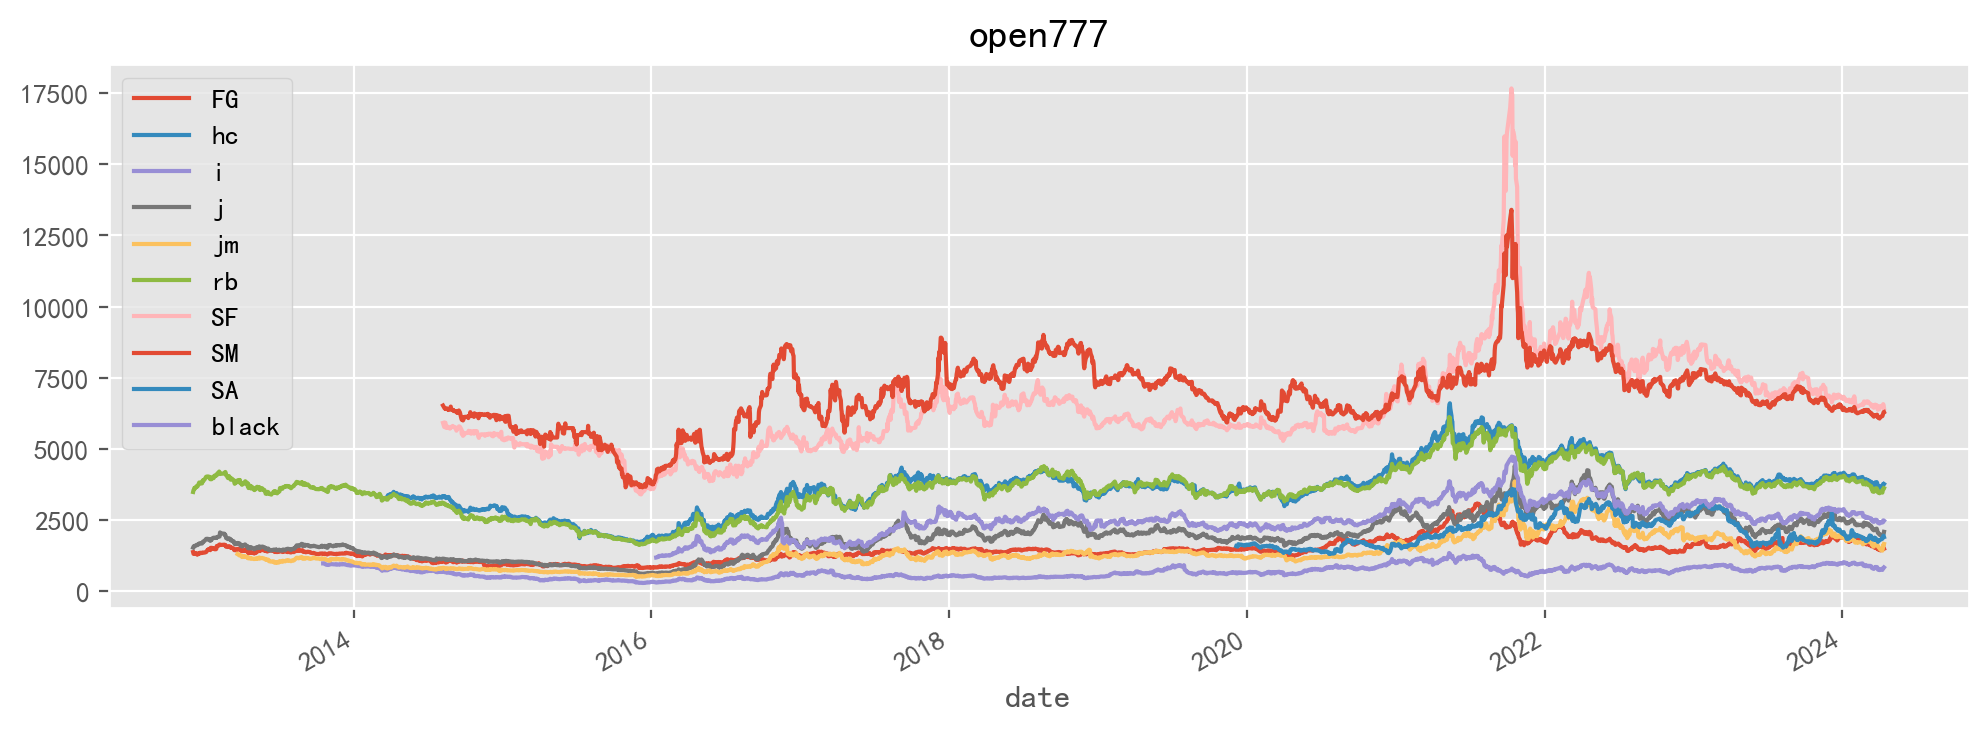

In [13]:
opens.plot(title=data_name)

## Backtest

In [7]:
# parse industry data
all_factors = pd.concat([arch_dec, auto, mech_equip, real_estate], axis=1)
all_factors = all_factors.loc[:, ~all_factors.columns.duplicated()]


In [ ]:
cols = [
        "variety",
        "factor_code",
        "factor_name",
        "yearly_return",
        "exceed_yr",
        "yearly_vol",
        "sharpe",
        "max_drawdown",
    ]

bt_long = pd.DataFrame(columns=cols)
bt_short = pd.DataFrame(columns=cols)
bt_ls = pd.DataFrame(columns=cols)

end_date = pd.to_datetime("2020-12-31")

for open in opens.columns:
    for factor in all_factors.columns:
        # get factor series
        factor_series = all_factors[factor]
        if isinstance(factor_series, pd.DataFrame):
            logger.warning(f"Multiple columns found in {factor}, using the first one")
            factor_series = factor_series.iloc[:, 0]

        # train data
        factor_series = factor_series.loc[:end_date]
        price = opens[open].loc[:end_date]

        # backtest        
        



for open in opens.columns:
    for factor in all_factors.columns:
        # get factor series
        factor_series = all_factors[factor]
        if isinstance(factor_series, pd.DataFrame):
            logger.warning(f"Multiple columns found in {factor}, using the first one")
            factor_series = factor_series.iloc[:, 0]

        # train data
        factor_series = factor_series.loc[:end_date]
        price = opens[open].loc[:end_date]

        # backtest
        try:
            factor_name = meta.loc[factor, "INDEX_SHORT_NAME"]
        except KeyError:
            logger.warning(f"Factor {factor} not found in meta, skipping")
            continue
        row_long, _ = utils.factor_test(price, factor_series, "long", logger)
        row_short, _ = utils.factor_test(price, factor_series, "short", logger)
        row_ls, _ = utils.factor_test(price, factor_series, "longshort", logger)

        row_info = pd.Series({
            "variety": open,
            "factor_code": factor,
            "factor_name": factor_name,
        })

        row_long = pd.concat([row_info, row_long])
        row_short = pd.concat([row_info, row_short])
        row_ls = pd.concat([row_info, row_ls])

        # save
        bt_long.loc[len(bt_long)] = row_long
        bt_short.loc[len(bt_short)] = row_short
        bt_ls.loc[len(bt_ls)] = row_ls

INFO:__main__:(FG, I_S000043163, long, 20201231): yr=2.93%,	eyr=-1.39%,	yv=22.36%,	sp=0.13,	md=49.54%
INFO:__main__:(FG, I_S000043163, short, 20201231): yr=-1.32%,	eyr=-5.65%,	yv=4.73%,	sp=-0.28,	md=17.46%
INFO:__main__:(FG, I_S000043163, longshort, 20201231): yr=1.30%,	eyr=-3.03%,	yv=22.85%,	sp=0.06,	md=52.52%
INFO:__main__:(FG, I_M004394057, long, 20201231): yr=-0.97%,	eyr=-9.43%,	yv=11.52%,	sp=-0.08,	md=15.00%
INFO:__main__:(FG, I_M004394057, short, 20201231): yr=-8.92%,	eyr=-17.38%,	yv=16.99%,	sp=-0.52,	md=46.02%
INFO:__main__:(FG, I_M004394057, longshort, 20201231): yr=-9.62%,	eyr=-18.08%,	yv=20.52%,	sp=-0.47,	md=47.97%
INFO:__main__:(FG, I_S002812996, long, 20201231): yr=1.45%,	eyr=-2.87%,	yv=15.01%,	sp=0.10,	md=39.65%
INFO:__main__:(FG, I_S002812996, short, 20201231): yr=-3.84%,	eyr=-8.16%,	yv=18.55%,	sp=-0.21,	md=56.95%
INFO:__main__:(FG, I_S002812996, longshort, 20201231): yr=-2.83%,	eyr=-7.16%,	yv=23.87%,	sp=-0.12,	md=71.86%
INFO:__main__:(FG, I_M001622745, long, 20201231): y

KeyboardInterrupt: 

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")

bt_long.to_csv("data/bt_long_single.csv", index=False, float_format="%.8f")
bt_short.to_csv("data/bt_short_single.csv", index=False, float_format="%.8f")
bt_ls.to_csv("data/bt_ls_single.csv", index=False, float_format="%.8f")

## Analysis

In [ ]:
asset_ls.to_csv("temp/asset.csv")

: 

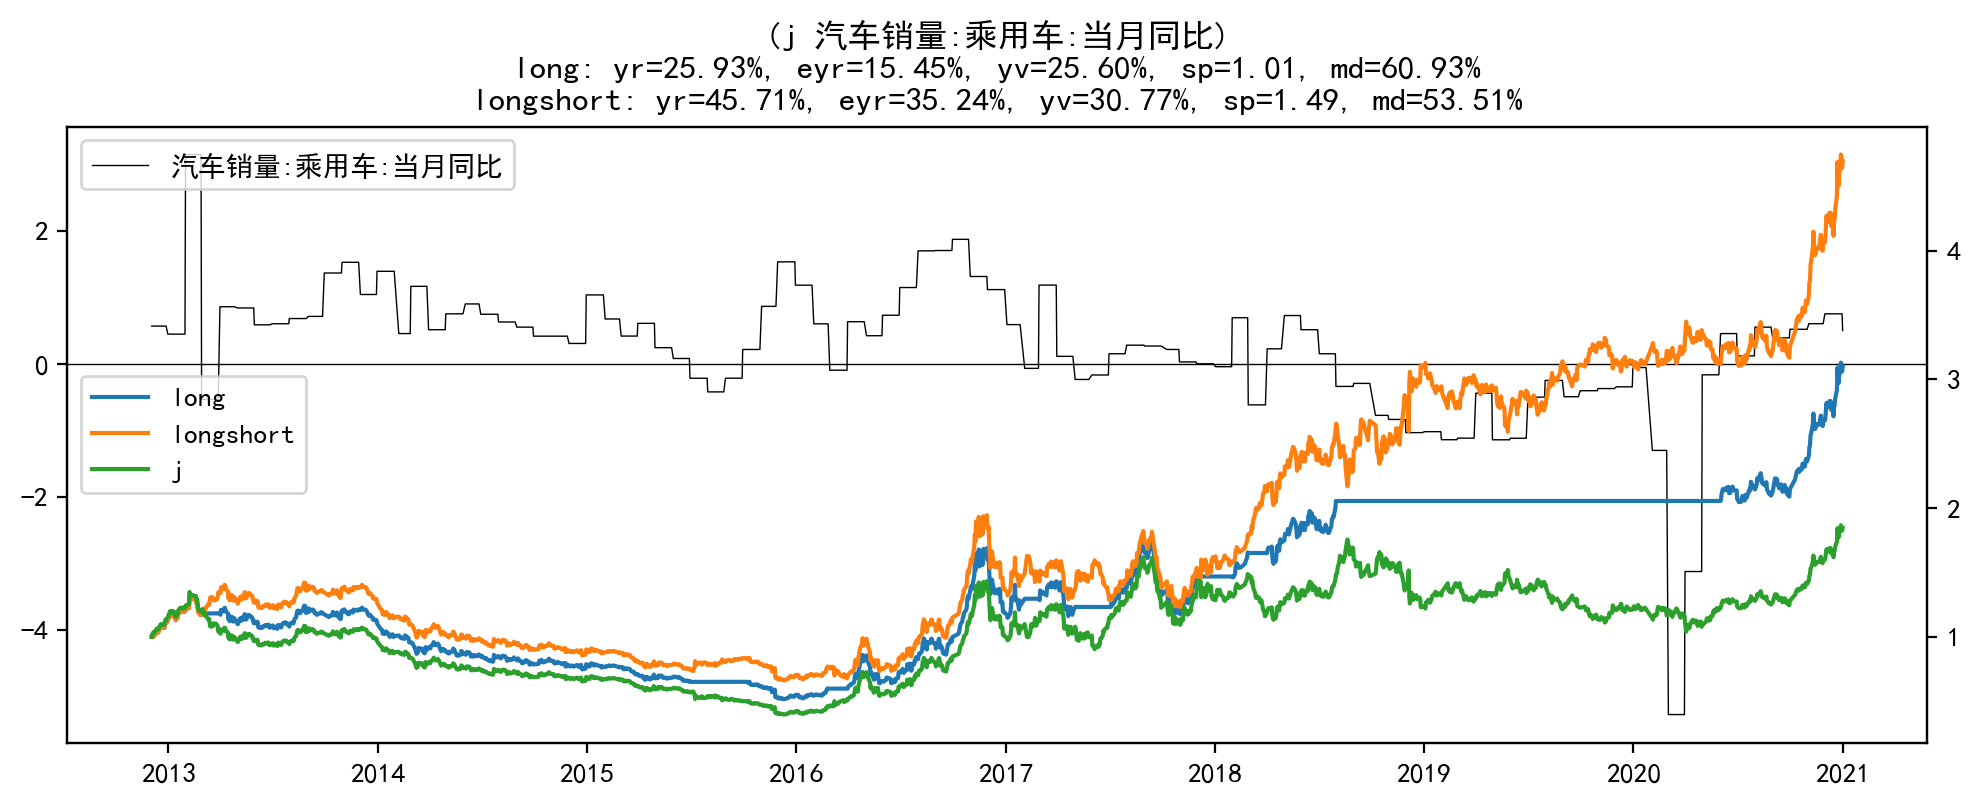

In [ ]:
# plot
variety = "j"
factor_code = "I_S002811529"
end_date = pd.to_datetime("2020-12-31")

factor_name = meta.loc[factor_code, "INDEX_SHORT_NAME"]
price = opens[variety].loc[:end_date]
factor = all_factors[factor_code].loc[:end_date]
price, factor = price.align(factor, join="inner")

row_long, asset_long = utils.factor_test(price, factor, "long")
row_ls, asset_ls = utils.factor_test(price, factor, "longshort")

_, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(utils.scale(factor, "divstd"), label=factor_name, color="black", linewidth=0.5)
ax1.axhline(0, color="black", linewidth=0.5)
ax2.plot(utils.scale(asset_long, "1stvalue"), label="long")
ax2.plot(utils.scale(asset_ls, "1stvalue"), label="longshort")
ax2.plot(utils.scale(price, "1stvalue"), label=variety)
ax1.legend(loc="upper left")
ax2.legend(loc="center left")

title = f"({variety} {factor_name})"
long_info = f"long: yr={row_long['yearly_return']:.2%}, eyr={row_long['exceed_yr']:.2%}, yv={row_long['yearly_vol']:.2%}, sp={row_long['sharpe']:.2f}, md={row_long['max_drawdown']:.2%}"
short_info = f"longshort: yr={row_ls['yearly_return']:.2%}, eyr={row_ls['exceed_yr']:.2%}, yv={row_ls['yearly_vol']:.2%}, sp={row_ls['sharpe']:.2f}, md={row_ls['max_drawdown']:.2%}"
plt.title(f"{title}\n{long_info}\n{short_info}")
plt.show()

In [ ]:
bt_long = pd.read_csv("data/bt_long_single.csv", index_col=None)
bt_short = pd.read_csv("data/bt_short_single.csv", index_col=None)
bt_ls = pd.read_csv("data/bt_ls_single.csv", index_col=None)
bt_ls["variety"].unique()

array(['FG', 'hc', 'i', 'j', 'jm', 'rb', 'SF', 'SM', 'SA', 'black'],
      dtype=object)

In [ ]:
bt_ls.sort_values("sharpe", ascending=False).head(10)

,variety,factor_code,factor_name,yearly_return,exceed_yr,yearly_vol,sharpe,max_drawdown
1126,j,I_S002811513,汽车产量:商用车:货车:累计同比,3.222874,3.118161,0.306359,10.519919,0.351872
1234,j,I_S009128891,制热:空气源热泵:销量:累计同比,2.345580,1.649179,0.366523,6.399552,0.483726
3409,black,I_S003052055,武汉:商品房:销售面积,1.472337,1.162512,0.350978,4.194958,0.265199
1102,j,I_M005383066,发动机:产量:累计同比,1.280169,1.175456,0.307778,4.159393,0.320548
1140,j,I_S002850762,销量:汽车起重机:累计同比,1.306948,1.202236,0.328271,3.981304,0.392379
3170,SA,I_S005109826,二手房均价:福建:莆田市:当周值,1.150862,1.137864,0.289099,3.980865,0.180728
1089,j,I_S002811529,汽车销量:乘用车:当月同比,1.249995,1.145283,0.321033,3.893666,0.428232
1562,jm,I_S005579571,农业机械:出口金额:累计同比,0.902786,0.454952,0.242208,3.727316,0.074429
1209,j,I_S005579571,农业机械:出口金额:累计同比,0.890618,0.216530,0.240244,3.707147,0.080116
1620,jm,I_S004543083,全国城市二手房出售挂牌价指数:当周值,1.160578,0.953773,0.326488,3.554731,0.262063


In [ ]:
bt_ls[bt_ls["sharpe"] >= 1].sort_values("sharpe", ascending=False).head()

,variety,factor_code,factor_name,yearly_return,exceed_yr,yearly_vol,sharpe,max_drawdown
1126,j,I_S002811513,汽车产量:商用车:货车:累计同比,3.222874,3.118161,0.306359,10.519919,0.351872
1234,j,I_S009128891,制热:空气源热泵:销量:累计同比,2.345580,1.649179,0.366523,6.399552,0.483726
3409,black,I_S003052055,武汉:商品房:销售面积,1.472337,1.162512,0.350978,4.194958,0.265199
1102,j,I_M005383066,发动机:产量:累计同比,1.280169,1.175456,0.307778,4.159393,0.320548
1140,j,I_S002850762,销量:汽车起重机:累计同比,1.306948,1.202236,0.328271,3.981304,0.392379


In [ ]:
bt_ls[bt_ls["sharpe"] >= 1].to_csv("data/ls_sharpe1.csv", index=False, float_format="%.8f")